# Analysis of Bitcoin Volatility

Here I study whether Bitcoin's volatility has been decreasing. It is widely reported that it has been the case, and indeed if one looks at Eli Dourado's [btcVol.info](http://www.btcvol.info) it seems to be the case. But is it the case?

[Here](https://llucpuigcodina.github.io/BTCEUR-Volatility/) there is a previous analysis by a friend of mine showing that using a very popular statistical test (Augmented Dickey-Fuller) to test whether a series is stationary, and the result is that the data is compatible with a stationary process. That is, the underlying distribution from which daily returns are drawn is constant across time.

In what follows, I replicate his study, showing some limitations of ADF.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()
%matplotlib inline
from forex_python.bitcoin import BtcConverter
b = BtcConverter()
_=b.get_latest_price('USD')


In [75]:
start_date=datetime.datetime(2011,1,1)
end_date=datetime.datetime(2017,1,1)
r=b.get_previous_price_list('USD', start_date, end_date)

In [76]:
data=pd.DataFrame.from_dict(r,orient='index')
data.columns=['Price']
data.sort_index(inplace=True)
data.index=pd.to_datetime(data.index)
data.reset_index(inplace=True)
data.rename(columns={'index':'Date'},inplace=True)
data.head()

,Date,Price
0,2011-01-01,0.300
1,2011-01-02,0.300
2,2011-01-03,0.295
3,2011-01-04,0.299
4,2011-01-05,0.299


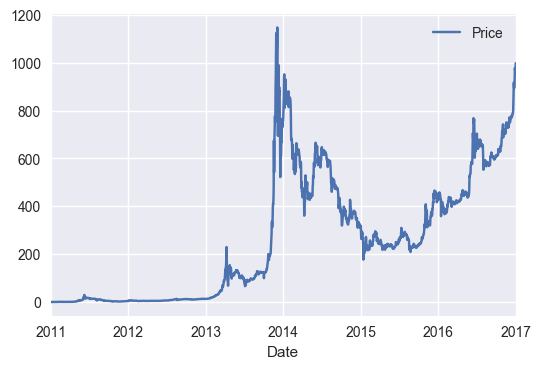

In [77]:
_=data.plot(x="Date",y="Price")

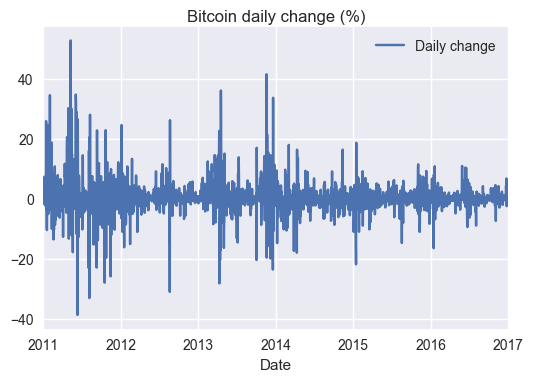

In [78]:
data['Daily change']=data['Price'].pct_change(1).multiply(100)
_=data.plot(title="Bitcoin daily change (%)",x='Date',y='Daily change')

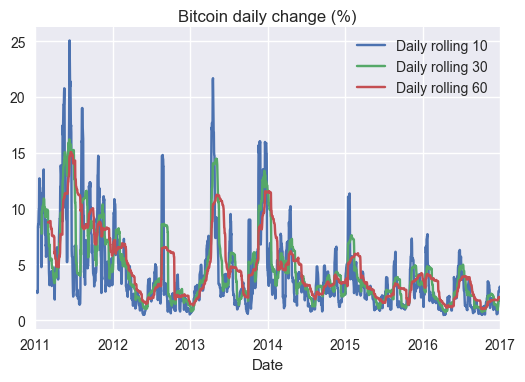

In [79]:
data['Daily rolling 10']=data['Daily change'].rolling(window=10,center=False).std()
data['Daily rolling 30']=data['Daily change'].rolling(window=30,center=False).std()
data['Daily rolling 60']=data['Daily change'].rolling(window=60,center=False).std()
plt.figure(figsize=(12,6))
_=ax=data.plot(title="Bitcoin daily change (%)",y='Daily rolling 10',x='Date')
_=data.plot(y='Daily rolling 30',x='Date',ax=ax)
_=data.plot(y='Daily rolling 60',x='Date',ax=ax)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Daily rolling 10   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     472.5
Date:                Sun, 08 Jan 2017   Prob (F-statistic):           5.36e-95
Time:                        12:48:59   Log-Likelihood:                -5749.0
No. Observations:                2183   AIC:                         1.150e+04
Df Residuals:                    2181   BIC:                         1.151e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9094      0.145     47.579      0.000         6.625     7.194
Date_n        -0.0025      0.000    -21.738      0.000        -0.003    -0.002
==============================================================================
Omnibus:                      812.011   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3098.355
Skew:                           1.818   Prob(JB):                         0.00
Kurtosis:                       7.565   Cond. No.                     2.55e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

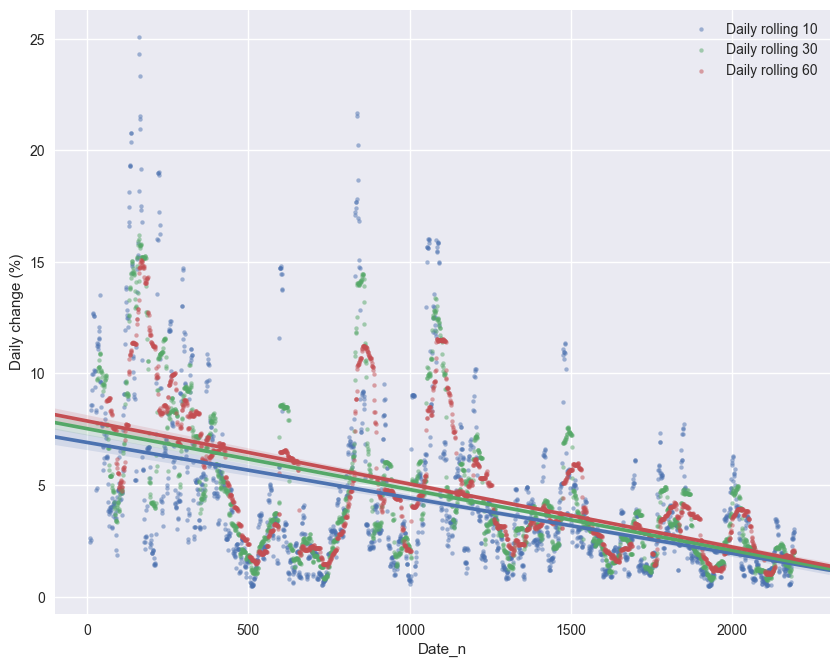

In [92]:
#First, we could do some curvefitting,
data['Date_n']=(data['Date']-data['Date'][0])/ np.timedelta64(1,'D')
fig=plt.figure(figsize=(10,8))
sns.regplot(data=data,x='Date_n',y='Daily rolling 10',scatter_kws={"s": 10,"alpha":0.5},label='Daily rolling 10')
sns.regplot(data=data,x='Date_n',y='Daily rolling 30',scatter_kws={"s": 10,"alpha":0.5},label='Daily rolling 30')
sns.regplot(data=data,x='Date_n',y='Daily rolling 60',scatter_kws={"s": 10,"alpha":0.5},label='Daily rolling 60')
plt.ylabel('Daily change (%)')
plt.legend()
import statsmodels.api as sm

y=data['Daily rolling 10']
X=data['Date_n']
mask = ~np.isnan(y)
X = X[mask]
y = y[mask]
model=sm.OLS(y,sm.add_constant(X),missing='drop').fit()
model.summary()

Perhaps it would be better to use a nonlinear function, something like an exponential with a decreasing term like  $f(x,a,b,c)=ae^{-xb}+c$ . For optimisation purposes, I noralise the series first.

Parameters: [ 0.26753345  1.07601779 -0.4516436 ]
Parameters: [ 0.36183029  1.01534461 -0.57939952]
Parameters: [ 0.42689696  0.98383072 -0.66565455]


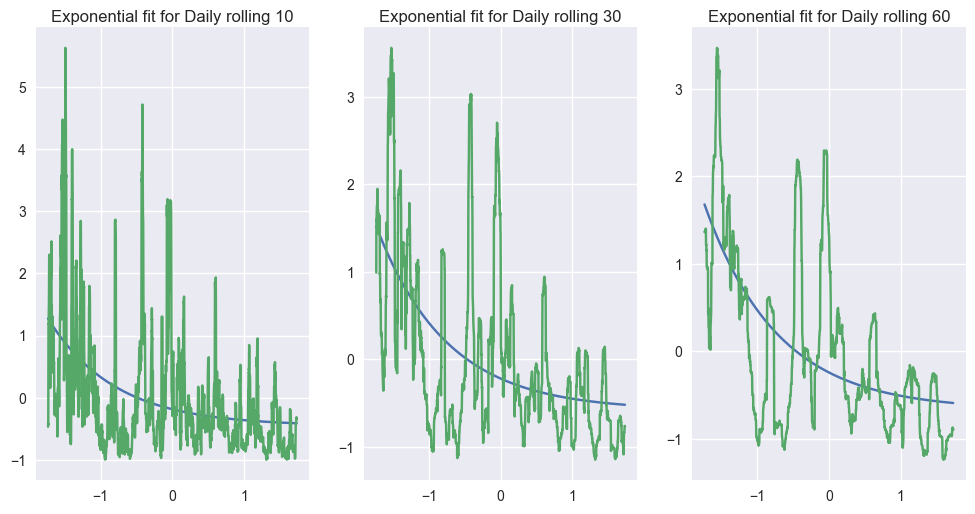

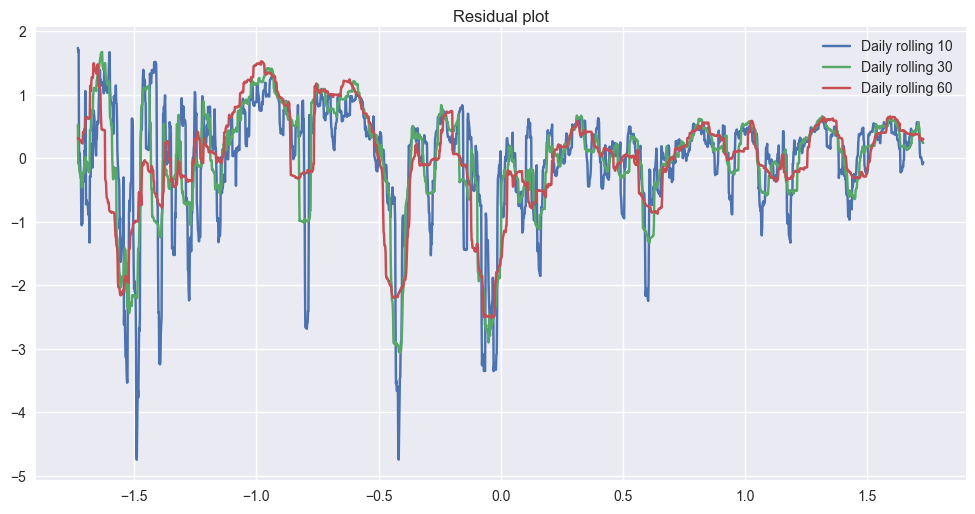

In [95]:
from scipy.optimize import curve_fit
from sklearn.preprocessing import normalize
def normalize(X,Y):
    mask = ~np.isnan(Y)
    X2 = X[mask]
    y2 = Y[mask]
    return (X2-np.mean(X2))/np.std(X2),(y2-np.mean(y2))/np.std(y2)
def func(x,a,b,c):
    return a*np.exp(-x*b)+c
def plot(X2,y2,popt,n):
    plt.subplot(1,3,n)
    plt.plot(X2,func(X2,popt[0],popt[1],popt[2]))
    plt.plot(X2,y2)

y=data['Daily rolling 10']
X=data['Date_n']
X1,y1=normalize(X,y)
popt1, pcov =curve_fit(func,X1,y1)
fig=plt.figure(figsize=(12,6))
plot(X1,y1,popt1,1)
plt.title('Exponential fit for Daily rolling 10')
print("Parameters:",popt1)


y=data['Daily rolling 30']
X=data['Date_n']
X2,y2=normalize(X,y)
popt2, pcov =curve_fit(func,X2,y2)
plot(X2,y2,popt2,2)
plt.title('Exponential fit for Daily rolling 30')
print("Parameters:",popt2)

y=data['Daily rolling 60']
X=data['Date_n']
X3,y3=normalize(X,y)
popt3, pcov =curve_fit(func,X3,y3)
plot(X3,y3,popt3,3)
plt.title('Exponential fit for Daily rolling 60')
print("Parameters:",popt3)

plt.figure(figsize=(12,6))
plt.plot(X1,func(X1,popt1[0],popt1[1],popt1[2])-y1,label='Daily rolling 10')
plt.plot(X2,func(X2,popt2[0],popt2[1],popt2[2])-y2,label='Daily rolling 30')
plt.plot(X3,func(X3,popt3[0],popt3[1],popt3[2])-y3,label='Daily rolling 60')
plt.title('Residual plot')
plt.legend()

I would say that the fit looks right (It seems to be exponentially decreasing, and it seems that variance is decreasing) especially if we remove some of the 'big' events like bubbles, etc.

Now we bring on ADF (Which I don't have experience using), checking the results we get for both a series with and without a trend. [Here](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html) there is the documentation for this function. First I run some tests to see how the function behaves. The parameter of interest is the second in the returned array, a pseudo p-value. I'll take it so that if p-value<0.05, we can't reject the null hypothesis

(0.030371082537879741,
 0.96097283593236305,
 5,
 94,
 {'1%': -3.5019123847798657,
  '10%': -2.5834538614757809,
  '5%': -2.8928152554828892},
 -130.36360151635336)

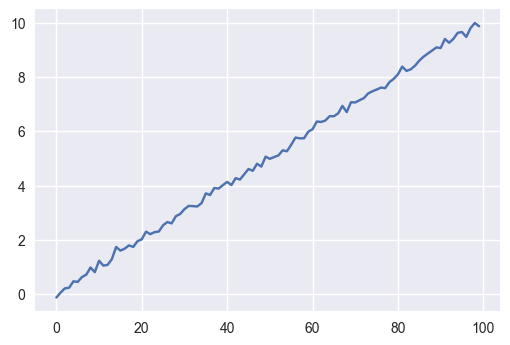

In [82]:
from statsmodels.tsa.stattools import adfuller
#Here there *is* a trend. Null hypothesis is: constant (The variable follows a random-walk)
#Because there is a trend, the test fails.
plt.plot(np.linspace(0,10, 100)+np.random.randn(100)/10)
adfuller(np.linspace(0,10, 100)+np.random.randn(100)/10)

Here there *is* a trend. So we tell the test that there is, and ask: does the trend change?

We can also do an ADF test assuming that there **is** a trend:

(-6.0891054304079377,
 1.4245907097885184e-06,
 3,
 96,
 {'1%': -4.0563093932201246,
  '10%': -3.1544345187717013,
  '5%': -3.4572550874385124},
 -161.30436800688932)

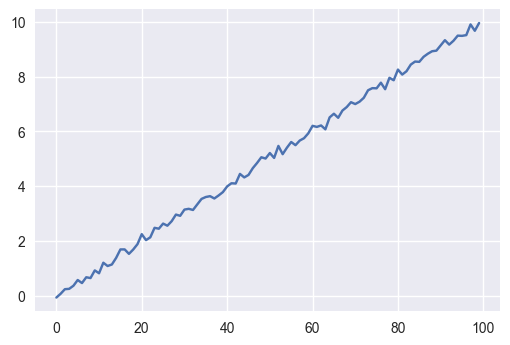

In [83]:
plt.plot(np.linspace(0,10, 100)+np.random.randn(100)/10)
adfuller(np.linspace(0,10, 100)+np.random.randn(100)/10,regression='ct')

In the next example there *is* a trend that *changes*, but from a constant underlying function, a sin(x).
The test still says the process doesn't change. Using the 'ct' option also says that the process doesn't change.
As the changing trend itself (a cosine) is also stationary around zero

(-14.936838558057197,
 2.3543437151057883e-22,
 22,
 977,
 {'1%': -3.9680661492141187,
  '10%': -3.1297006047557043,
  '5%': -3.4149932715005722},
 -8471.9770767955488)

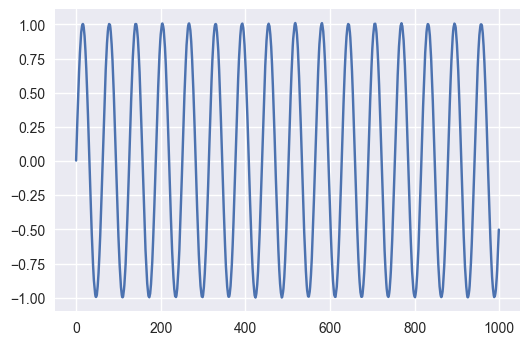

In [84]:

np.random.seed(42)
n=1000
space=np.linspace(0,100,n)
var=np.concatenate([np.sin(space[:n//2]),np.sin(space[n//2:])])+np.random.rand(n)/100
plt.plot(var)
adfuller(var,regression='ct')

We can now try to see what would the test say if it saw the function we just fitted.

(-16.794102051514088,
 1.2352461745010984e-29,
 25,
 2107,
 {'1%': -3.4334573966160153,
  '10%': -2.5675007703726296,
  '5%': -2.8629127187998606},
 -18524.80171562676)

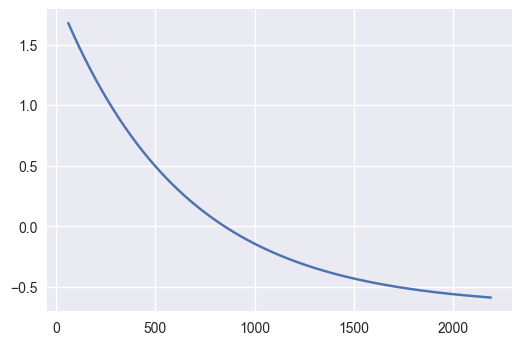

In [85]:
plt.plot(func(X3,popt3[0],popt3[1],popt3[2]))
adfuller(func(X3,popt3[0],popt3[1],popt3[2])+np.random.rand(len(X3))/100)

So *even if* the variance were decreasing given a very clean equation, the test would still say that the process is stationary, so the test is not that much useful after all.

Ok, let's go back to our Bitcoins and do the actual test

In [86]:
def nice(data,regtype="c"):
    return adfuller(data.dropna(),regression=regtype)[1]

print("P-value for 10 days averaged volatility: ",nice(data['Daily rolling 10']),'***')
print("P-value for 30 days averaged volatility: ",nice(data['Daily rolling 30']),'***')
print("P-value for 60 days averaged volatility: ",nice(data['Daily rolling 60']),'**')

P-value for 10 days averaged volatility:  8.59786631742e-05 ***
P-value for 30 days averaged volatility:  0.000113952000692 ***
P-value for 60 days averaged volatility:  0.034705270592 **


Thus we find that indeed for the 10 days average volatility, the data is consistent with a process with constant variance, and that remains valid for greater windows of averaging.

Let's now examine what happens if instead, we consider as our hypothesis that the series follows a trend (y=ax+b)

In [87]:
print("P-value for 10 days averaged volatility: ",nice(data['Daily rolling 10'],'ct'),'***')
print("P-value for 30 days averaged volatility: ",nice(data['Daily rolling 30'],'ct'),'***')
print("P-value for 60 days averaged volatility: ",nice(data['Daily rolling 60'],'ct'),'**')

P-value for 10 days averaged volatility:  4.36675365203e-05 ***
P-value for 30 days averaged volatility:  5.24203107756e-05 ***
P-value for 60 days averaged volatility:  0.0309130608266 **


Surprise surprise, the test also says this is true! ** We cannot reject the fact that the series is generated by a process with decreasing variance either! **

For completion, below I show the ADF test for a number of possible lags. The test by default choses one using the Bayesian Information Criterion.

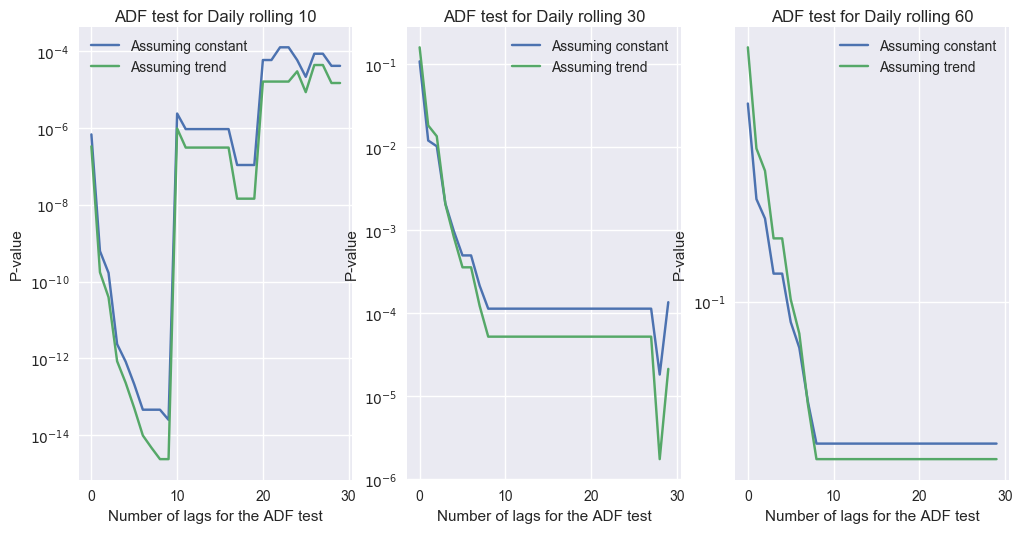

In [88]:
def makeplot(name,pos):
    plt.subplot(1,3,pos)
    for i in range(n_lags):
        pvalues[i,0]=adfuller(data[name].dropna(),regression='c',maxlag=i)[1]
        pvalues[i,1]=adfuller(data[name].dropna(),regression='ct',maxlag=i)[1]
    plt.plot(range(n_lags),pvalues)
    plt.yscale('log', nonposy='clip')
   
    plt.ylabel('P-value')
    plt.xlabel('Number of lags for the ADF test')
    plt.legend(['Assuming constant','Assuming trend'])
    plt.title('ADF test for '+name)
i=1
n_lags=30
pvalues=np.zeros((n_lags,2))
fig=plt.figure(figsize=(12,6))
makeplot('Daily rolling 10',1)
makeplot('Daily rolling 30',2)
makeplot('Daily rolling 60',3)


# Conclusion

The ADF test is not very useful for a time series like the BTC-USD exchange rate. Here I would go with plain OLS,that says that the coefficient of the feature 'date' is negative at the 95% confidence level. This trend persist even if we consider only, say, post 2014 or post 2015 data. Using a nonlinear exponential fit is even better.

Thus the data warrants the conclusion that Bitcoin is, after all, becoming less volatile.